<a href="https://colab.research.google.com/gist/carlthome/542a9899dedcb2c7adf3403df3fe1f14/proximal-policy-optimization-ppo-of-the-cartpole-problem-with-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import torch
import numpy as np

In [ ]:
class Memory:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.history = {
            "state": [],
            "probs": [],
            "values": [],
            "action": [],
            "reward": [],
            "done": [],
        }

    def generate_batches(self):
        num_states = len(self.history["state"])
        batch_start = np.arange(0, num_states, self.batch_size)
        indices = np.arange(num_states, dtype=np.int64)
        np.random.shuffle(indices)
        rows = [indices[i : i + self.batch_size] for i in batch_start]
        batches = {k: np.array(v) for k, v in self.history.items()}
        batches["batches"] = rows
        return batches

    def append(self, row):
        for k, v in row.items():
            self.history[k].append(v)

    def clear(self):
        for k in self.history:
            self.history[k].clear()

In [ ]:
class Actor(torch.nn.Module):
    def __init__(
        self,
        num_actions,
        input_dims,
        alpha,
        fc1_dims=256,
        fc2_dims=256,
        chkpt_dir="tmp/ppo",
    ):
        super().__init__()
        self.checkpoint_file = os.path.join(chkpt_dir, "actor_torch_ppo")

        self.actor = torch.nn.Sequential(
            torch.nn.Linear(*input_dims, fc1_dims),
            torch.nn.ReLU(),
            torch.nn.Linear(fc1_dims, fc2_dims),
            torch.nn.ReLU(),
            torch.nn.Linear(fc2_dims, num_actions),
            torch.nn.Softmax(dim=-1),
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = torch.distributions.categorical.Categorical(dist)
        return dist

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [ ]:
class Critic(torch.nn.Module):
    def __init__(
        self, input_dims, alpha, fc1_dims=256, fc2_dims=256, chkpt_dir="tmp/ppo"
    ):
        super().__init__()
        self.checkpoint_file = os.path.join(chkpt_dir, "critic_torch_ppo")
        self.critic = torch.nn.Sequential(
            torch.nn.Linear(*input_dims, fc1_dims),
            torch.nn.ReLU(),
            torch.nn.Linear(fc1_dims, fc2_dims),
            torch.nn.Linear(fc2_dims, 1),
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)
        return value

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [ ]:
class Agent:
    def __init__(
        self,
        num_actions,
        input_dims,
        gamma=0.99,
        alpha=1e-3,
        gae_lambda=0.95,
        policy_clip=0.2,
        batch_size=64,
        N=2048,
        num_epochs=10,
    ):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.num_epochs = num_epochs
        self.gae_lambda = gae_lambda

        self.actor = Actor(num_actions, input_dims, alpha)
        self.critic = Critic(input_dims, alpha)
        self.memory = Memory(batch_size)

    def remember(self, state, action, probs, values, reward, done):
        row = {
            "state": state,
            "probs": probs,
            "values": values,
            "action": action,
            "reward": reward,
            "done": done,
        }
        self.memory.append(row)

    def save_models(self):
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = torch.tensor(np.asarray([observation]), dtype=torch.float).to(self.actor.device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = torch.squeeze(dist.log_prob(action)).item()
        action = torch.squeeze(action).item()
        value = torch.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.num_epochs):

            batches = self.memory.generate_batches()
            state_history = batches["state"]
            old_probs_history = batches["probs"]
            values_history = batches["values"]
            action_history = batches["action"]
            reward_history = batches["reward"]
            dones_history = batches["done"]
            batches = batches["batches"]

            values = values_history
            advantage = np.zeros(len(reward_history), dtype=np.float32)
            for t in range(len(reward_history) - 1):
                discount = 1.0
                a_t = 0
                for k in range(t, len(reward_history) - 1):
                    a_t += discount * (
                        reward_history[k]
                        + self.gamma * values[k + 1] * (1 - int(dones_history[k]))
                        - values[k]
                    )
                    discount *= self.gamma * self.gae_lambda
                advantage[t] = a_t

            advantage = torch.tensor(advantage).to(self.actor.device)

            values = torch.tensor(values).to(self.actor.device)

            for batch in batches:
                states = torch.tensor(state_history[batch], dtype=torch.float).to(self.actor.device)
                old_probs = torch.tensor(old_probs_history[batch]).to(self.actor.device)
                actions = torch.tensor(action_history[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = torch.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()

                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = (
                    torch.clamp(prob_ratio, 1 - self.policy_clip, 1 + self.policy_clip)
                    * advantage[batch]
                )

                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns - critic_value) ** 2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5 * critic_loss

                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()

                total_loss.backward()

                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear()

# Experiments


In [ ]:
!mkdir -p tmp/ppo

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

env = gym.make("CartPole-v1", new_step_api=True)
env.action_space.seed(42)
steps_per_update = 20
batch_size = 5
num_epochs = 4
alpha = 1e-3

agent = Agent(
    num_actions=env.action_space.n,
    batch_size=batch_size,
    alpha=alpha,
    num_epochs=num_epochs,
    input_dims=env.observation_space.shape,
)

num_episodes = 300
score = 0
score_history = []
best_score = env.reward_range[0]
num_updates = 0
num_steps = 0

records = []
for episode in tqdm.trange(num_episodes, desc="Training"):
    observation = env.reset()
    terminated = False
    truncated = False
    score = 0
    while not terminated and not truncated:
        action, prob, val = agent.choose_action(observation)

        new_observation, reward, terminated, truncated, info = env.step(action)
        num_steps += 1
        score += reward

        done = truncated or terminated
        agent.remember(observation, action, prob, val, reward, done)

        if num_steps % steps_per_update == 0:
            agent.learn()
            num_updates += 1

        observation = new_observation

    score_history.append(score)

    avg_score = np.mean(score_history[-100:])
    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    record = {
        "Episode": episode,
        "Score": score,
        "Average Score": avg_score,
        "Best Score": best_score,
        "Step": num_steps,
        "Updates": num_updates,
    }
    records.append(record)

Training:   0%|          | 0/300 [00:00<?, ?it/s]

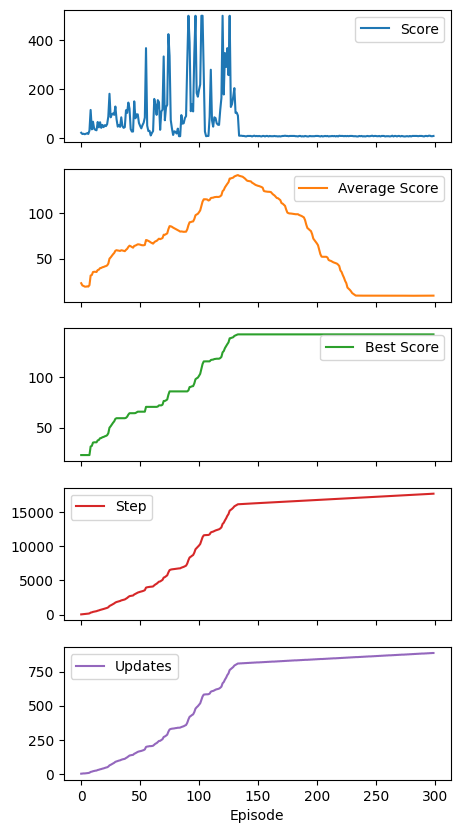

In [ ]:
import pandas as pd

pd.DataFrame(records).set_index("Episode").plot(subplots=True, figsize=(5, 10));